In [17]:
import csv

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv('data/fer2013/fer2013.csv')

In [19]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1]
        image = np.array(image.split(), dtype='float32').reshape(48, 48)
        image = image[:, :, np.newaxis]  # (48, 48, 1) 형태로 변경
        label = int(self.data.iloc[idx, 0])

        if self.transform:
            image = self.transform(image)  # ToTensor() 적용 시 (1,48,48)

        return image, label

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [21]:
dataset = FER2013Dataset(csv_file='data/fer2013/fer2013.csv', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

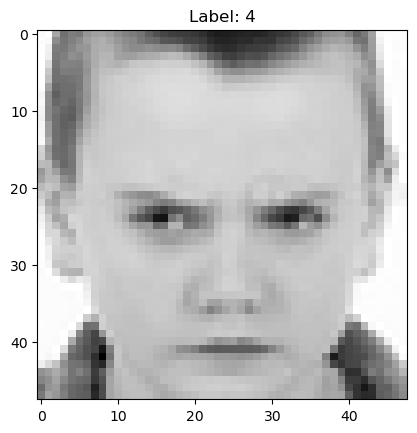

(48, 48)


In [22]:
image, label = train_dataset[0]

# Convert the image tensor to a numpy array and squeeze to remove the channel dimension
image = image.numpy().squeeze()

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()
print(image.shape)

In [23]:
import os
from torch import nn

In [24]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [25]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) ,#48->48
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),#48->24
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) ,#24->24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #24->12
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=12*12*64, out_features=6*6*64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(num_features=6*6*64),
            nn.Linear(in_features=6*6*64, out_features=7),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=7),
            nn.Linear(in_features=7, out_features=7),
        )
    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x
        logits = self.linear_relu_stack(x)
        return logits

In [26]:
model = ConvNet()
model.to(device)

ConvNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9216, out_features=2304, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(2304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2304, out_features=7, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=7, out_features=7, bias=True)
  )
)

In [27]:
lr = 5e-4
batch_size = 128
epochs = 20
weight_decay=1e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [28]:
hyper_parameters = {}
hyper_parameters['batch_size'] = batch_size
hyper_parameters['epochs'] = epochs
hyper_parameters['lr'] = lr
hyper_parameters['weight_decay'] = weight_decay
hyper_parameters['loss_fn'] = loss_fn
hyper_parameters['optimizer'] = optimizer

In [29]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
def train_loop(dataloader, model, loss_fn, optimizer, show_step = True):
    size = len(dataloader.dataset)
    model.train()
    ls = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ls = loss.item()
        if batch % 100 == 0 and show_step:
            loss, current = loss.item(), batch *batch_size+len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return ls

def test_loop(dataloader, model, loss_fn, show_step = True):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if show_step:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [31]:
def loop_epoch(epoch, train_loader, test_loader, model, loss_fn, optimizer, show_step):
    acc_history = []
    for t in range(epoch):
        if show_step:
            print(f"Epoch {t+1}\n-------------------------------")
        else:
            print(f"\r Epoch{t+1} running", end="")
        train_loop(train_loader, model, loss_fn, optimizer, show_step)
        acc = test_loop(test_loader, model, loss_fn, show_step)
        acc_history.append(acc)
    print("Done!")
    return acc_history

In [32]:
acc_history = loop_epoch(epochs, train_loader, test_loader, model, loss_fn, optimizer, show_step=False)

 Epoch1 running

KeyboardInterrupt: 

In [28]:
print(f"max:{max(acc_history)} epoch:{acc_history.index(max(acc_history))}")

0.49679576483700194


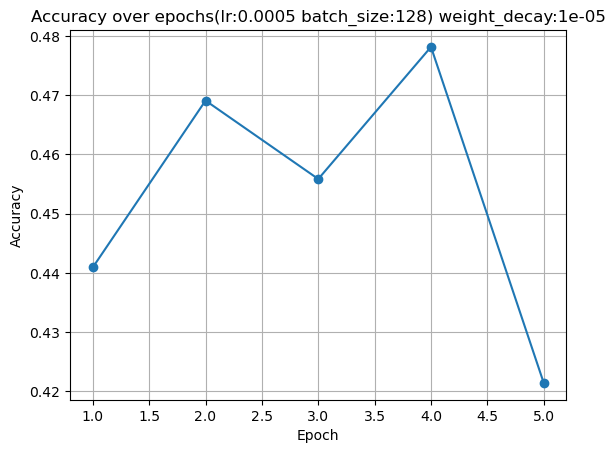

In [19]:
plt.plot(range(1, epochs + 1), acc_history, marker='o')
plt.title(f"Accuracy over epochs(lr:{lr} batch_size:{batch_size}) weight_decay:{weight_decay}")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()